# 2016-11-04: Tree-based methods
In this lab, we will apply tree-based classification methods to the Endometrium vs. Uterus cancer data. For documentation see: http://scikit-learn.org/0.17/modules/tree.html

Let us start, as usual, by setting up our environment, loading the data, and setting up our cross-validation.

In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data
X = np.loadtxt('data/small_Endometrium_Uterus.csv',  delimiter=',', skiprows=1, usecols=range(1, 3001))

# Python 2.7 only
y = np.loadtxt('data/small_Endometrium_Uterus.csv', delimiter=',', skiprows=1, usecols=[3001], 
               converters={3001: lambda s: 0 if s=='Endometrium' else 1}, dtype='int')

In [3]:
# Normalize the data
from sklearn import preprocessing
X = preprocessing.normalize(X)

In [4]:
# Set up a stratified 10-fold cross-validation
from sklearn import cross_validation
folds = cross_validation.StratifiedKFold(y, 10, shuffle=True)

In [5]:
def cross_validate(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns the predictions. 
   
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - predict_proba(X) to apply the trained classifier to the data X and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]
        #print Xtr.shape, ytr.shape, Xte.shape

        # Fit classifier
        classifier.fit(Xtr, ytr)

        # Predict probabilities (of belonging to +1 class) on test data
        yte_pred = classifier.predict_proba(Xte)
        index_of_class_1 = 1 - ytr[0] # 0 if the first sample is positive, 1 otherwise
        pred[te] = yte_pred[:, index_of_class_1]
    return pred

## 1. Decision trees

**Question** Cross-validate 5 different decision trees, with default parameters. 

In [29]:
from sklearn import tree
from sklearn import metrics

clf = tree.DecisionTreeClassifier()

ypred_dt = [] # will hold the 5 arrays of predictions (1 per tree)
for tree_index in range(5):
    ypred = cross_validate(X, y, clf, folds)
    ypred_dt.append(ypred)

**Question** Compute the mean and standard deviation of the area under the ROC curve of these 5 trees. Plot the ROC curves of these 5 trees.

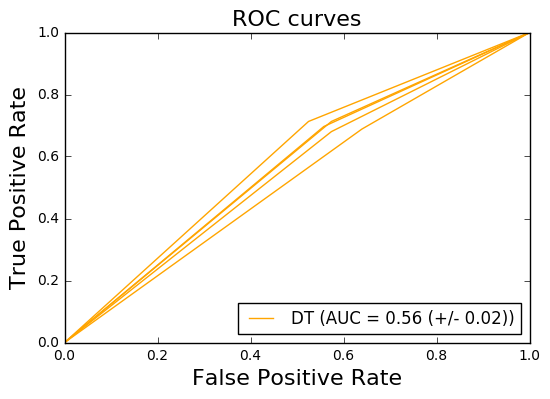

In [30]:
fpr_dt = [] # will hold the 5 arrays of false positive rates (1 per tree)
tpr_dt = [] # will hold the 5 arrays of true positive rates (1 per tree)
auc_dt = [] # will hold the 5 areas under the ROC curve (1 per tree)
for tree_index in range(5):
    fpr, tpr, thresholds = metrics.roc_curve(y, ypred_dt[tree_index], pos_label=1)
    fpr_dt.append(fpr)
    tpr_dt.append(tpr)
    auc_dt.append(metrics.auc(fpr, tpr))
    
for tree_index in range(4):
    plt.plot(fpr_dt[tree_index], tpr_dt[tree_index], '-', color='orange') 
plt.plot(fpr_dt[-1], tpr_dt[-1], '-', color='orange', 
         label='DT (AUC = %0.2f (+/- %0.2f))' % (np.mean(auc_dt), np.std(auc_dt)))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right")

**Question** What parameters of DecisionTreeClassifier can you play with to define trees differently than with the default parameters? Cross-validate these using a grid search, and plot the optimal decision tree on the previous plot. Did you manage to improve performance?

You can play with the criterion and the splitter. Yes, it improved the performances (better auc)

In [41]:
from sklearn import grid_search
param_grid = {'criterion':["entropy"]}
clf = grid_search.GridSearchCV(tree.DecisionTreeClassifier(), param_grid, scoring='roc_auc')
ypred_dt_opt = cross_validate(X, y, clf, folds)
fpr_dt_opt, tpr_dt_opt, thresholds = metrics.roc_curve(y, ypred_dt_opt, pos_label=1)
auc_dt_opt = metrics.auc(fpr_dt_opt, tpr_dt_opt)

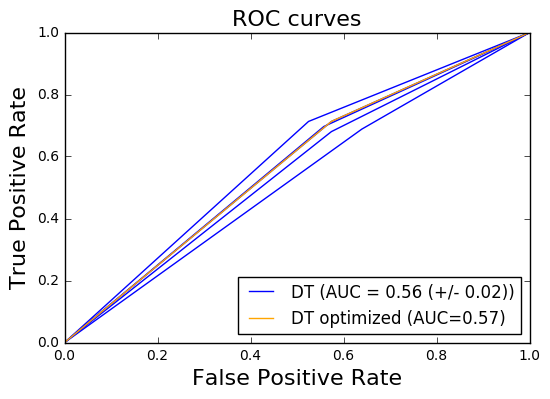

In [42]:
# Plot the 5 decision trees from earlier
for tree_index in range(4):
    plt.plot(fpr_dt[tree_index], tpr_dt[tree_index], '-', color='blue') 
plt.plot(fpr_dt[-1], tpr_dt[-1], '-', color='blue', 
         label='DT (AUC = %0.2f (+/- %0.2f))' % (np.mean(auc_dt), np.std(auc_dt)))
# Plot the optimized decision tree 
plt.plot(fpr_dt_opt, tpr_dt_opt, color='orange', label='DT optimized (AUC=%0.2f)' % auc_dt_opt)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right")

**Question** How does the performance of decision trees compare to the performance of classifiers we have used previously on this data? Does this match your expectations?

We had better results with previous classifiers

## 2. Bagging trees

We will resort to ensemble methods to try to improve the performance of single decision trees. Let us start with bagging trees: The different trees are to be built using a bagging sample of the data, that is to say, a sample built by using as many data points, drawn *with replacement* from the original data.

**Note:** Bagging trees and random forests start making sense when using large number of trees (several hundreds). This is computationally more intensive, especially when the number of features is large, as in this lab. For the sake of computational time, I suggested using small numbers of trees, but you might want to repeat this lab for larger number of trees at home.

**Question** Cross-validate a bagging ensemble of 5 decision trees on the data. Plot the resulting ROC curve, compared to the 5 decision trees you trained earlier.

In [43]:
from sklearn import ensemble
# By default, the base estimator is a decision tree with default parameters
clf = ensemble.BaggingClassifier(n_estimators=5)

ypred_dt = [] # will hold the 5 arrays of predictions (1 per tree)
for tree_index in range(5):
    ypred = cross_validate(X, y, clf, folds)
    ypred_dt.append(ypred)

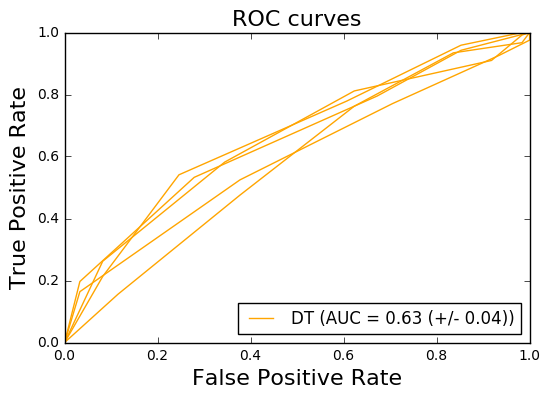

In [44]:
fpr_dt = [] # will hold the 5 arrays of false positive rates (1 per tree)
tpr_dt = [] # will hold the 5 arrays of true positive rates (1 per tree)
auc_dt = [] # will hold the 5 areas under the ROC curve (1 per tree)
for tree_index in range(5):
    fpr, tpr, thresholds = metrics.roc_curve(y, ypred_dt[tree_index], pos_label=1)
    fpr_dt.append(fpr)
    tpr_dt.append(tpr)
    auc_dt.append(metrics.auc(fpr, tpr))
    
for tree_index in range(4):
    plt.plot(fpr_dt[tree_index], tpr_dt[tree_index], '-', color='orange') 
plt.plot(fpr_dt[-1], tpr_dt[-1], '-', color='orange', 
         label='DT (AUC = %0.2f (+/- %0.2f))' % (np.mean(auc_dt), np.std(auc_dt)))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right")

**Question** Use ``cross_validate_optimize`` (as defined in the previous lab) to optimize the number of decision trees to use in the bagging method. How many trees did you find to be an optimal choice?

In [45]:
def cross_validate_optimize(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns the predictions. 
   
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn GridSearchCV object
        GridSearchCV instance; must have the following methods/attributes:
        - fit(X, y) to train the classifier on the data X, y
        - predict_proba(X) to apply the trained classifier to the data X and return probability estimates 
    cv_folds: sklearn cross-validation object
        - best_params_ the best parameter dictionary
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vector of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]
        #print Xtr.shape, ytr.shape, Xte.shape

        # Fit classifier
        classifier.fit(Xtr, ytr)
        
        # Print best parameter
        print classifier.best_params_

        # Predict probabilities (of belonging to +1 class) on test data
        yte_pred = classifier.predict_proba(Xte)
        index_of_class_1 = 1 - ytr[0] # 0 if the first sample is positive, 1 otherwise
        pred[te] = yte_pred[:, index_of_class_1]  
    return pred

In [48]:
param_grid = {'n_estimators': [5, 15, 25, 50]}

clf = grid_search.GridSearchCV(ensemble.BaggingClassifier(), param_grid, scoring='roc_auc')

ypred = cross_validate_optimize(X, y, clf, folds)

{'n_estimators': 25}
{'n_estimators': 15}
{'n_estimators': 50}
{'n_estimators': 25}
{'n_estimators': 50}
{'n_estimators': 50}
{'n_estimators': 50}
{'n_estimators': 15}
{'n_estimators': 50}
{'n_estimators': 50}


**Question** Plot the ROC curve of the optimized cross-validated bagging tree classifier obtained with `cross_validate_optimize`, and compare it to the previous ROC curves (non-optimized bagging tree, decision trees). 

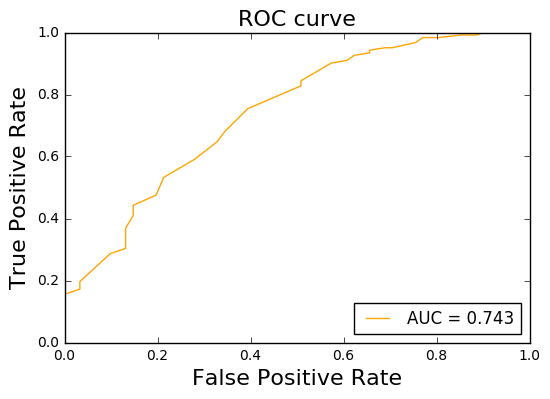

In [52]:
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y, ypred, pos_label=1)

# Area under the ROC curve
auc = metrics.auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, '-', color='orange', label='AUC = %0.3f' % auc)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right")

## 3. Random forests

We will now use random forests.

**Question** What is the difference between bagging trees and random forests?

**Question** Cross-validate a random forest of 5 decision trees on the data. Plot the resulting ROC curve, compared to the 5 decision trees you trained earlier, and the bagging tree made of 5 decision trees.

In [53]:
clf = ensemble.RandomForestClassifier(n_estimators=5) 

ypred = cross_validate(X, y, clf, folds)


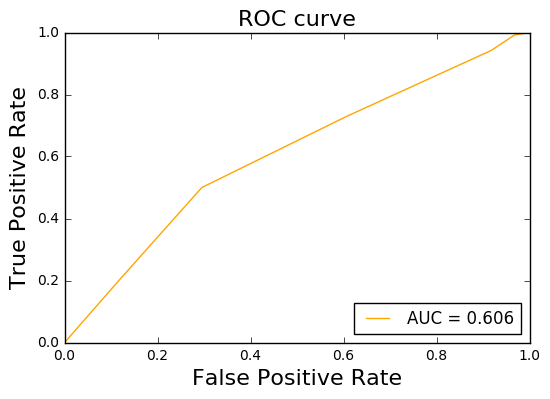

In [54]:
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y, ypred, pos_label=1)

# Area under the ROC curve
auc = metrics.auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, '-', color='orange', label='AUC = %0.3f' % auc)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right")

**Question** Use ``cross_validate_optimize`` (as defined in the previous lab) to optimize the number of decision trees to use in the random forest. How many trees do you find to be an optimal choice? How does the optimal random forest compare to the optimal bagging trees? How do the training times of the random forest and the bagging trees compare?

In [55]:
param_grid = {'n_estimators': [5, 15, 25, 50]}

clf = grid_search.GridSearchCV(ensemble.RandomForestClassifier(), param_grid, scoring='roc_auc')

ypred = cross_validate_optimize(X, y, clf, folds)

{'n_estimators': 50}
{'n_estimators': 50}
{'n_estimators': 15}
{'n_estimators': 25}
{'n_estimators': 50}
{'n_estimators': 50}
{'n_estimators': 50}
{'n_estimators': 50}
{'n_estimators': 50}
{'n_estimators': 50}


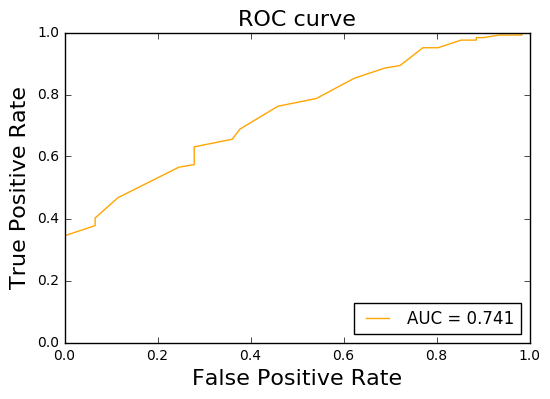

In [56]:
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y, ypred, pos_label=1)

# Area under the ROC curve
auc = metrics.auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, '-', color='orange', label='AUC = %0.3f' % auc)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right")

**Question** How do your tree-based classifiers compare to the linear regression (regularized or not)? Plot ROC curves.

In [57]:
from sklearn import linear_model
param_grid = {'C':[1e-3, 1e-2, 1e-1, 1., 1e2, 1e3]}
clf = grid_search.GridSearchCV(linear_model.LogisticRegression(penalty='l1'), 
                               param_grid, scoring='roc_auc')
ypred_l1 = cross_validate_optimize(X, y, clf, folds)
fpr_l1, tpr_l1, thresholds_l1 = metrics.roc_curve(y, ypred_l1, pos_label=1)

clf = grid_search.GridSearchCV(linear_model.LogisticRegression(penalty='l2'), 
                               param_grid, scoring='roc_auc')
ypred_l2 = cross_validate_optimize(X, y, clf, folds)
fpr_l2, tpr_l2, thresholds_l2 = metrics.roc_curve(y, ypred_l2, pos_label=1)

{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}


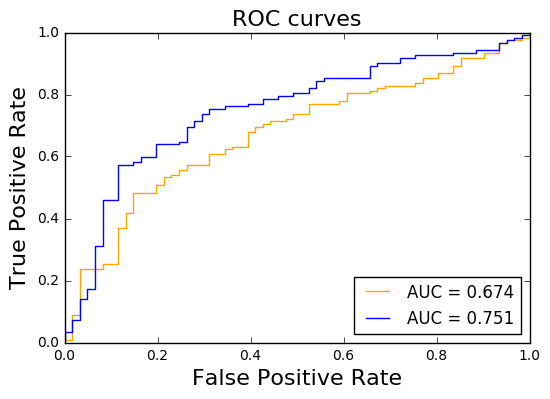

In [59]:
# Area under the ROC curve
auc_l1 = metrics.auc(fpr_l1, tpr_l1)
auc_l2 = metrics.auc(fpr_l2, tpr_l2)
# Plot the ROC curve
plt.plot(fpr_l1, tpr_l1, '-', color='orange', label='AUC = %0.3f' % auc_l1)
plt.plot(fpr_l2, tpr_l2, '-', color='blue', label='AUC = %0.3f' % auc_l2)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right")

## Kaggle challenge
You can find the documentation for tree-based regression here: 
* What parameters can you change?
* Cross-validate several different tree-based regressors (trees and tree ensembles) on your data, using the folds you previously set up. How do the different variants of decision trees compare to each other? How do they compare to performance obtained with other algorithms?
* Submit predictions to the leaderboard for the best of your tree-based models. Do the results on the leaderboard data match your expectations?